In [12]:
### Library Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

### Function to Get Commodities Data
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start=start_date, end=end_date)['Adj Close']
    # Drop rows with NaN values
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    # Reset the index
    data.reset_index(inplace = True)
    return data

# Function Call
commodities_list = ['SIL=F', 'HG=F']
start_date = '2016-07-01'
end_date = '2024-07-01'
commod_data = import_commod_data(commodities_list, start_date, end_date)
print("Data Head:")
print(commod_data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data Head:
        Date      SIL=F    HG=F
0 2016-07-01  19.544001  2.2150
1 2016-07-05  19.865999  2.1815
2 2016-07-06  20.160000  2.1515
3 2016-07-07  19.798000  2.1225
4 2016-07-08  20.058001  2.1185


In [21]:
### Function to Compute Spread
def compute_spread(stock1_data, stock2_data):
    # Taking the natural logarithm of the stock prices
    Y = np.log(stock2_data)
    X = np.log(stock1_data)
    # Adding a constant term to the independent variable (X) for the intercept
    X = sm.add_constant(X)
    # Fitting the Ordinary Least Squares (OLS) regression model
    model = sm.OLS(Y, X)
    results = model.fit()
    # Extracting the regression parameters alpha (intercept) and beta (slope)
    alpha = results.params.values[0]
    beta = results.params.values[1]

    # Calculating the spread (residuals) as the difference between the actual Y and the predicted Y
    errors = Y - (alpha + X.iloc[:, 1] * beta)
    
    return errors, alpha, beta

### Compute Spread
# Assume your data is structured with 'Close' columns for each commodity
stock1_data = commod_data[commodities_list[0]]
stock2_data = commod_data[commodities_list[1]]
# Compute Spread
spread, alpha, beta = compute_spread(stock1_data, stock2_data)
print(f"Regression parameters: alpha = {round(alpha, 4)}, beta = {round(beta, 4)}")
print("Spread Tail:")
print(spread.head())


Regression parameters: alpha = -1.2804, beta = 0.8228
Spread Tail:
0   -0.370301
1   -0.398986
2   -0.424921
3   -0.423583
4   -0.436205
dtype: float64


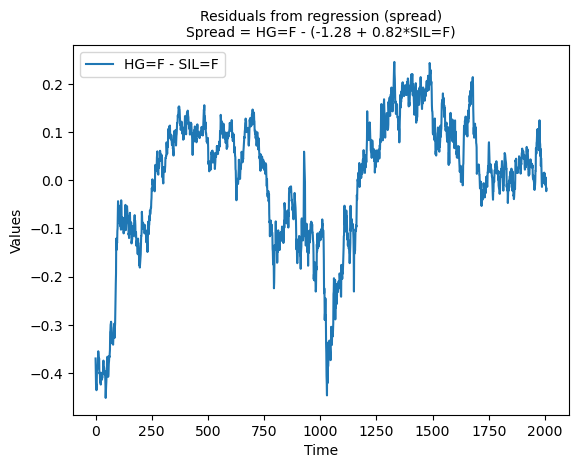

In [14]:
### Plotting the Spread
commod1_name = commodities_list[0]
commod2_name = commodities_list[1]

spread.plot(label=f"{commod2_name} - {commod1_name}")
plt.title(f'Residuals from regression (spread)\nSpread = {commod2_name} - ({alpha:.2f} + {beta:.2f}*{commod1_name})', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


In [15]:
### Implement the ADF Test
def adf_test(spread):
    # Performing the Augmented Dickey-Fuller test on the provided series
    result = adfuller(spread.dropna())

    print("Results of Dickey-Fuller Test:")
    print('ADF Statistic:', round(result[0], 4))
    print('p-value:', round(result[1], 4))
    print('Number of Lags Used:', round(result[2], 4))
    print('Number of Observations Used:', round(result[3], 4))

    # Printing the critical values for the test statistic at different significance levels
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {round(value, 4)}')
    # Printing the Maximized Information Criterion (AIC)
    print('Maximized Information Criterion (AIC):', round(result[5], 4))

    # Interpreting the p-value to determine stationarity
    p_val = result[1]
    if p_val < 0.05:
        print(f'Since the p value of: {round(p_val, 4)} < 0.05, we reject the null hypothesis and conclude the data is stationary')
    else:
        print(f'Since the p value of: {round(p_val, 4)} > 0.05, we fail to reject the null hypothesis and conclude the data is non-stationary')

    # Interpretation of ADF Statistic relative to Critical Values
    adf_stat = result[0]
    critical_values = result[4]
    print(f"Note that the Dickey-Fuller test result {round(adf_stat, 4)} lays between the critical values:")
    if adf_stat < critical_values['1%']:
        print("The test statistic is less than the 1% critical value; therefore, we reject the null hypothesis at the 1% level, concluding the data is stationary at the 1% significance level.")
    elif adf_stat < critical_values['5%']:
        print("The test statistic is less than the 5% critical value; therefore, we reject the null hypothesis at the 5% level, concluding the data is stationary at the 5% significance level.")
    elif adf_stat < critical_values['10%']:
        print("The test statistic is less than the 10% critical value; therefore, we reject the null hypothesis at the 10% level, concluding the data is stationary at the 10% significance level.")
    else:
        print("The test statistic is greater than the 10% critical value; therefore, we fail to reject the null hypothesis, concluding the data is non-stationary at the 10%, 5%, and 1% significance levels.")

### Perform Dickey-Fuller Test on Spread
adf_test(spread)


Results of Dickey-Fuller Test:
ADF Statistic: -3.2724
p-value: 0.0162
Number of Lags Used: 1
Number of Observations Used: 2006
Critical Values:
   1%: -3.4336
   5%: -2.863
   10%: -2.5675
Maximized Information Criterion (AIC): -10676.5399
Since the p value of: 0.0162 < 0.05, we reject the null hypothesis and conclude the data is stationary
Note that the Dickey-Fuller test result -3.2724 lays between the critical values:
The test statistic is less than the 5% critical value; therefore, we reject the null hypothesis at the 5% level, concluding the data is stationary at the 5% significance level.


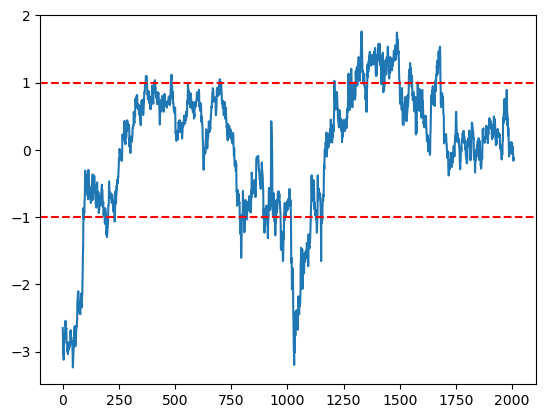

Z-score Head:
0   -2.648775
1   -2.853964
2   -3.039481
3   -3.029907
4   -3.120191
dtype: float64


In [16]:
### Compute the Z-score and Plot
def compute_zscore(spread):
    # Calculating the mean and standard deviation of the spread
    mean = spread.mean()
    stddev = spread.std()
    # Calculating the Z-score of the spread
    zscore = (spread - mean) / stddev

    # Plotting the Z-score
    zscore.plot()
    # Adding horizontal lines at Z-score = 1, Z-score = -1, and Z-score = 0
    plt.axhline(1, color='r', linestyle='--')
    plt.axhline(-1, color='r', linestyle='--')
    plt.show()

    return zscore

zscore = compute_zscore(spread)
print("Z-score Head:")
print(zscore.head())


In [17]:
### Create Signals Function
def signals(zscore, commod_data, signal_entry, signal_exit):
    # Ensure zscore is aligned with commod_data by setting the same index
    zscore.index = commod_data.index
    
    # Empty DataFrame to store signals
    signals_df = pd.DataFrame()
    # Populate the DataFrame with the signals
    signals_df = commod_data.copy()
    # Generate short signals
    signals_df['short_signal'] = (zscore > signal_entry) & (zscore.shift(1) <= signal_entry)
    signals_df['short_exit'] = (zscore < signal_exit) & (zscore.shift(1) >= signal_exit)
    # Generate long signals
    signals_df['long_signal'] = (zscore < -signal_entry) & (zscore.shift(1) >= -signal_entry)
    signals_df['long_exit'] = (zscore > -signal_exit) & (zscore.shift(1) <= -signal_exit)
    
    return signals_df[['short_signal', 'short_exit', 'long_signal', 'long_exit']]

signals_df = signals(zscore, commod_data, signal_entry = 1, signal_exit = -1)
print(signals_df.tail())


      short_signal  short_exit  long_signal  long_exit
2003         False       False        False      False
2004         False       False        False      False
2005         False       False        False      False
2006         False       False        False      False
2007         False       False        False      False


In [18]:
### Perform Backtesting
def perform_backtest(signals_df, commod_data):
    backtest_result = []
    spread_side = None  # This variable tracks the current position type: 'short', 'long', or None
    counter = -1  # This is used to help index the previous data point since DataFrame.iterrows() does not naturally handle this

    for time, signals_stock in signals_df.iterrows():
        counter += 1
        # Extracting signal data from the current row
        short_signal = signals_stock['short_signal']
        short_exit = signals_stock['short_exit']
        long_signal = signals_stock['long_signal']
        long_exit = signals_stock['long_exit']

        # Implementing the logic to calculate returns based on the position
        if spread_side == "long":
            # Calculate returns if in a long position
            if counter > 0:  # Ensure there is a previous row to compare with
                return_sil_f = commod_data.iloc[counter]['SIL=F'] / commod_data.iloc[counter - 1]['SIL=F'] - 1
                return_hg_f = -(commod_data.iloc[counter]['HG=F'] / commod_data.iloc[counter - 1]['HG=F'] - 1)
            if long_exit:
                spread_side = None  # Exit long position
        elif spread_side == "short":
            # Calculate returns if in a short position
            if counter > 0:  # Ensure there is a previous row to compare with
                return_sil_f = -(commod_data.iloc[counter]['SIL=F'] / commod_data.iloc[counter - 1]['SIL=F'] - 1)
                return_hg_f = commod_data.iloc[counter]['HG=F'] / commod_data.iloc[counter - 1]['HG=F'] - 1
            if short_exit:
                spread_side = None  # Exit short position
        else:
            return_sil_f = 0
            return_hg_f = 0
            # Determine whether to start a new long or short position
            if short_signal:
                spread_side = "short"
            elif long_signal:
                spread_side = "long"

        # Append the results for this iteration to the list
        backtest_result.append([time, return_sil_f, return_hg_f, spread_side or "None"])

    # Create DataFrame from results
    backtest_df = pd.DataFrame(backtest_result, columns=['Time', 'Return_SIL=F', 'Return_HG=F', 'Spread_Side'])
    return backtest_df

backtest_result = perform_backtest(signals_df, commod_data)
print("\nBacktest Result Head:")
print(backtest_result.tail())



Backtest Result Head:
      Time  Return_SIL=F  Return_HG=F Spread_Side
2003  2003      0.002840     0.007343       short
2004  2004      0.022110    -0.032251       short
2005  2005     -0.002497    -0.003082       short
2006  2006     -0.000311    -0.008930       short
2007  2007     -0.011031     0.014324       short


                               Date  Return_SIL=F  Return_HG=F   Side  \
Date                                                                    
1970-01-01 00:00:00.000002003  2003      0.002840     0.007343  short   
1970-01-01 00:00:00.000002004  2004      0.022110    -0.032251  short   
1970-01-01 00:00:00.000002005  2005     -0.002497    -0.003082  short   
1970-01-01 00:00:00.000002006  2006     -0.000311    -0.008930  short   
1970-01-01 00:00:00.000002007  2007     -0.011031     0.014324  short   

                               Total_PL  
Date                                     
1970-01-01 00:00:00.000002003 -0.749227  
1970-01-01 00:00:00.000002004 -0.751948  
1970-01-01 00:00:00.000002005 -0.753330  
1970-01-01 00:00:00.000002006 -0.755609  
1970-01-01 00:00:00.000002007 -0.754843  


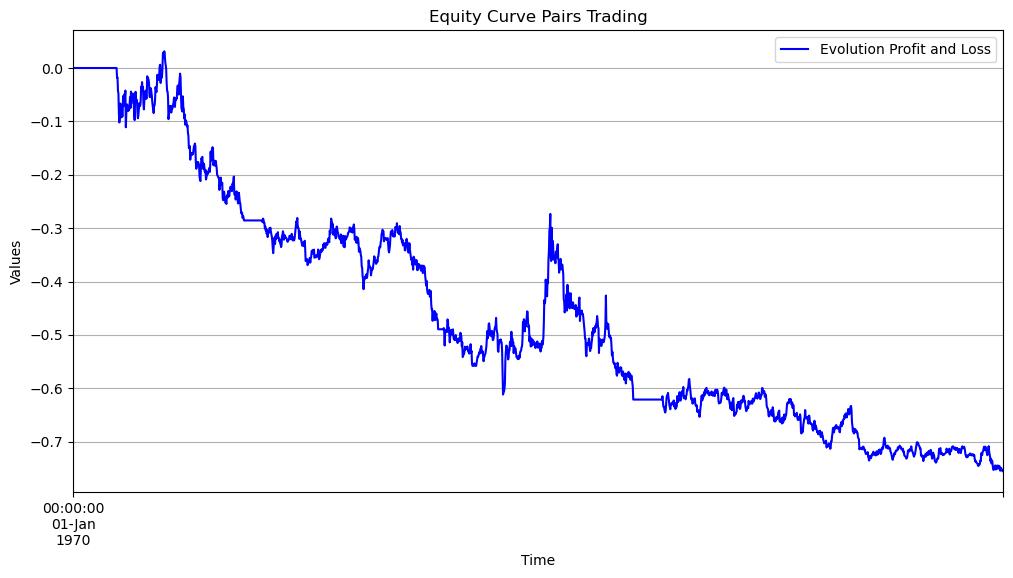

In [19]:
### Calculate Cululative Returns and Plot
backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ['Date', 'Return_SIL=F', 'Return_HG=F', 'Side']
backtest_pandas['Return_SIL=F'] = backtest_pandas['Return_SIL=F'].astype(float)
backtest_pandas['Return_HG=F'] = backtest_pandas['Return_HG=F'].astype(float)
backtest_pandas['Total_PL'] = (1 + backtest_pandas['Return_SIL=F']).cumprod() * (1 + backtest_pandas['Return_HG=F']).cumprod() - 1
backtest_pandas.index = pd.to_datetime(backtest_pandas['Date'])
plt.figure(figsize=(12, 6))
backtest_pandas['Total_PL'].plot(label='Evolution Profit and Loss', color='blue')
print(backtest_pandas.tail(5))
plt.title('Equity Curve Pairs Trading')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()